<a href="https://colab.research.google.com/github/skyler-ud/FDSFE_SLindsey/blob/main/labs/instructions_fittinglinetogrbafterglows_traintestsplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry WITH VALIDATION

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [ ]:
import pandas as pd
import pylab as pl
%pylab inline

# I have created a stylesheet to define default plot behaviors.
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [ ]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/HW1/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [ ]:
grbAG.tail()

,filter,time,mag,magerr,upperlimit
114,W1,63738,NaN,21.20,1
115,M2,74798,NaN,21.59,1
116,U,128928,NaN,20.05,1
117,V,971360,NaN,22.09,1
118,V,1171176,NaN,21.16,1


In [ ]:
grbAG.time

,time
0,66
1,67
2,68
3,69
4,70
...,...
114,63738
115,74798
116,128928
117,971360


# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [ ]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

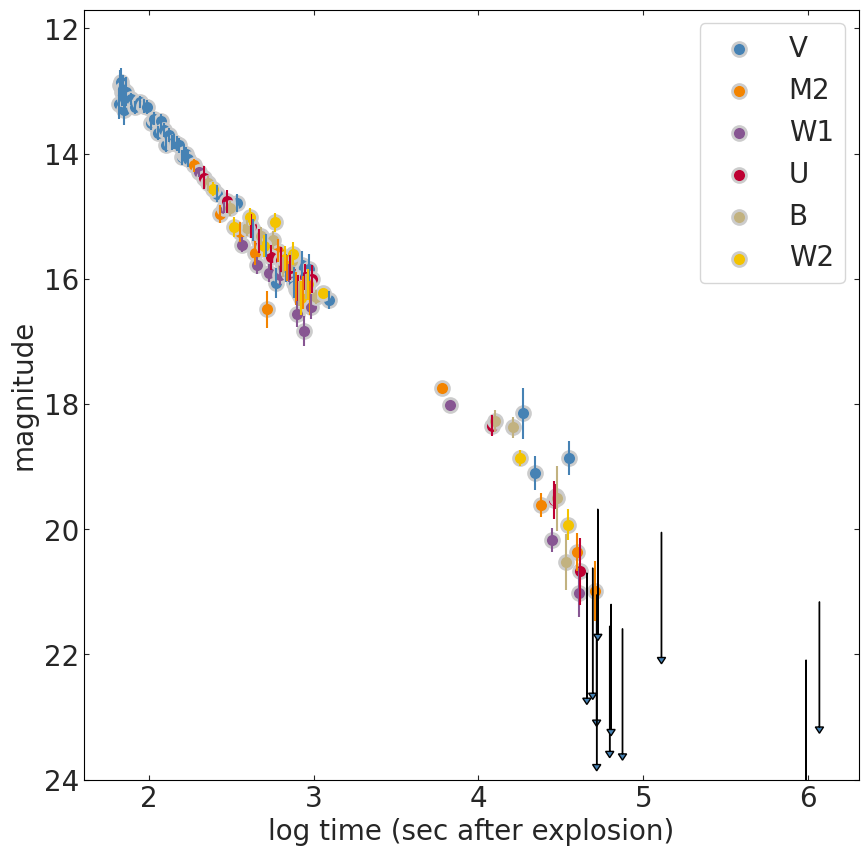

In [ ]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

In [ ]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values
#note the shape in python is flipped compared to the shape in linear algebra

# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.



# Fit a line to the data (excluding the upper limits) by minimizing an objective function on the training set. test it on the test set

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [ ]:
#define utility functions

def line(x, intercept, slope):
    return slope * x + intercept

def chi2(args, x, y, s):
    a, b = args
    return sum((y - line(x, a, b))**2 / s)

def Rsquare(args, x, y):
    a, b = args
    return 1 - (1 / x.shape[0]) * sum((y - line(x, a, b))**2) / np.std(y)**2


In [ ]:
x.shape,y.shape,s.shape

((108,), (108,), (108,))

# split training and test set (incorrectly!)

In [ ]:
x_train_wrong, x_test_wrong = x[:75],x[75:]
y_train_wrong, y_test_wrong = y[:75],y[75:]
s_train_wrong, s_test_wrong = s[:75],s[75:]

# RIGHT DATA SPLIT

In [ ]:
from sklearn.model_selection import train_test_split


x_train_right, x_test_right, y_train_right, y_test_right, s_train_right, s_test_right = train_test_split(x, y, s, test_size=0.25, random_state=42)

In [ ]:
from scipy.optimize import minimize
model_wrong = minimize(chi2, (10,1), args=(x_train_wrong, y_train_wrong, s_train_wrong))

In [ ]:
model_right = minimize(chi2, (10,1), args=(x_train_right, y_train_right, s_train_right))

In [ ]:
print("intercept, slope", model_wrong.x)

intercept, slope [7.50100249 2.96127966]


In [ ]:
print("intercept, slope", model_right.x)

intercept, slope [8.66427995 2.46972727]


In [ ]:
def plotline(pars, x, color='k', symbol='-', label='model', ax=ax):
    slope, intercept = pars
    y = line(x, intercept, slope)
    ax.plot(x, y, ls=symbol, c=color, label=label)

def plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, linepars=None):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #Use pl.errorbar to plot the uncertainties

  pl.errorbar(x_train, y_train, s_train, fmt='.', ms=0,
                fcolor=None, label=None, color='SteelBlue')

  pl.errorbar(x_test, y_test, s_test, fmt='.', ms=0,
                fcolor=None, label=None, color='IndianRed')

  pl.scatter(x_train, y_train,
             s=100, alpha=1, linewidth=2,
             label="training", color='SteelBlue')

  pl.scatter(x_test, y_test,
            alpha=1, s=100, linewidth=2,
           label="testing", color='IndianRed')

  if not linepars is None:
    plotline(linepars[:2], linepars[2], ax=ax, label=linepars[3])


  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time (sec after explosion)", fontsize=20);
  return ax



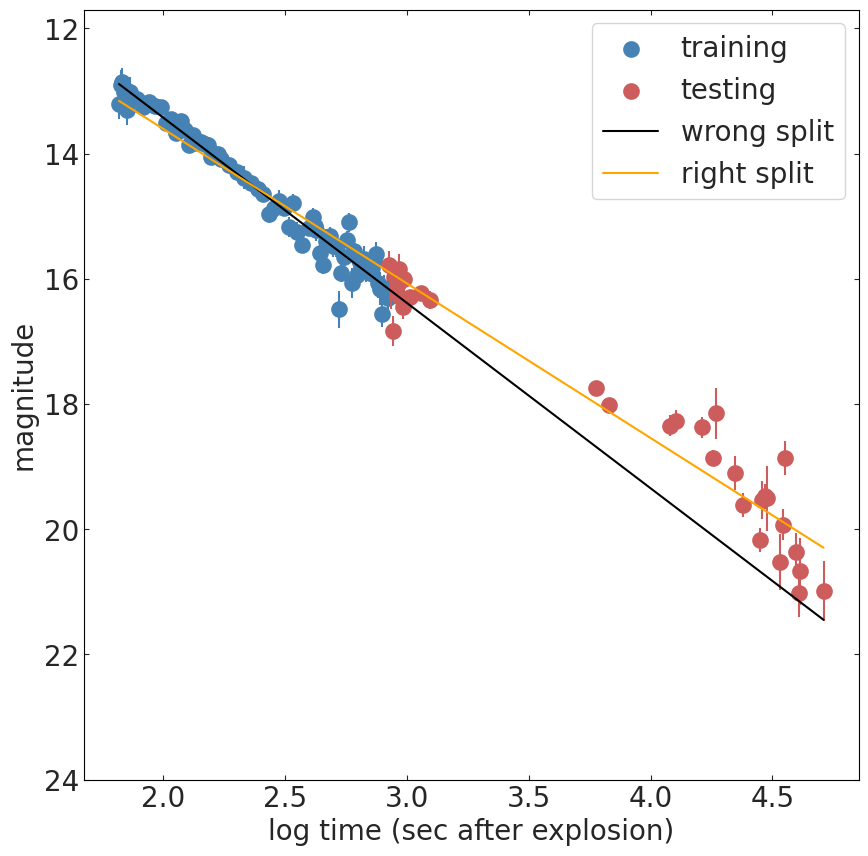

In [ ]:
ax = plotdatapoints(x_train_wrong, y_train_wrong, s_train_wrong,
                    x_test_wrong, y_test_wrong, s_test_wrong)
plotline(model_wrong.x[::-1], x, ax = ax, label="wrong split")
plotline(model_right.x[::-1], x, ax = ax, label="right split", color='orange')
plt.legend()

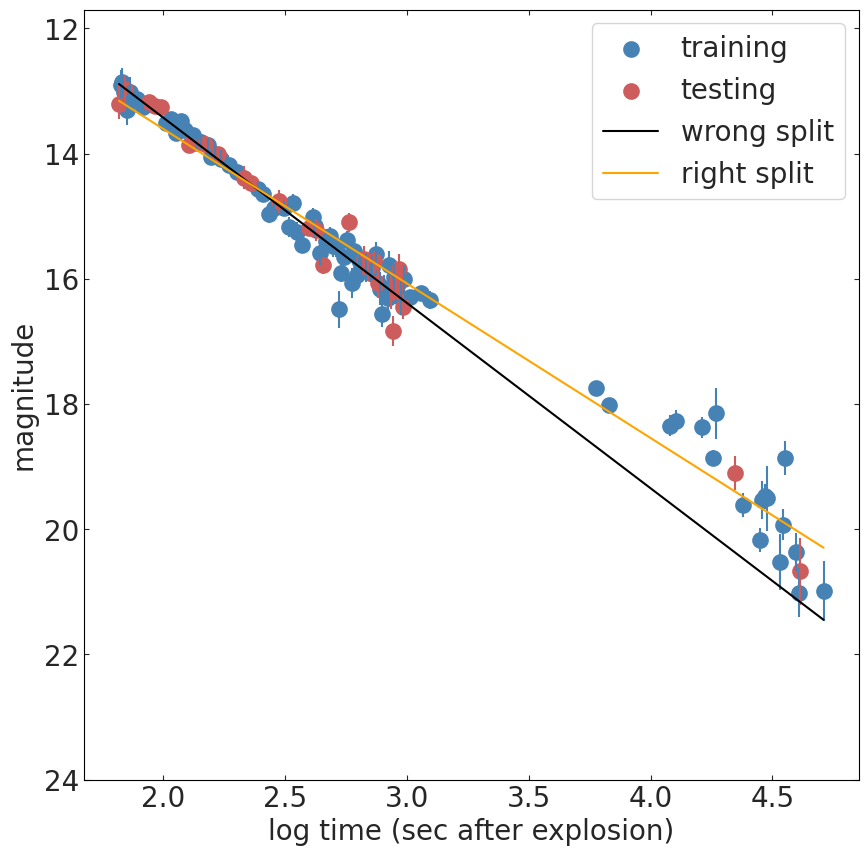

In [ ]:
ax = plotdatapoints(x_train_right, y_train_right, s_train_right,
                    x_test_right, y_test_right, s_test_right)
plotline(model_wrong.x[::-1], x, ax = ax, label="wrong split")
plotline(model_right.x[::-1], x, ax = ax, label="right split", color='orange')
plt.legend()